## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [3]:
# run once if imblearn isn't already installed
!pip install imblearn

In [1]:
# load in basic packages

import numpy as np
import pandas as pd

# load in packages for graphs and charts
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# load in other packages

#import scipy as sp
import sklearn as sk


from itertools import combinations


# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from sklearn.datasets import make_classification
from collections import Counter

# model related
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold

# model tuning
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

# data preprocessing where needed
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 

# scoring and accuracy related
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score

#from test_results import test_results, score


In [6]:
# load in the Starbucks training data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [32]:
# Udacity note:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [7]:
# look at basic metrics for training data
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [8]:
# look at training data file structure
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [9]:
# look at the training data counts of those that receive promotion and those that don't
promotion_yes = train_data[train_data['Promotion'] == 'Yes'].count()[2]
promotion_no = train_data[train_data['Promotion'] == 'No'].count()[2]
print('Promotion Yes: ', promotion_yes/train_data.count()[0])
print('Promotion No: ', promotion_no/train_data.count()[0])

Promotion Yes:  0.5011474672912675
Promotion No:  0.4988525327087326


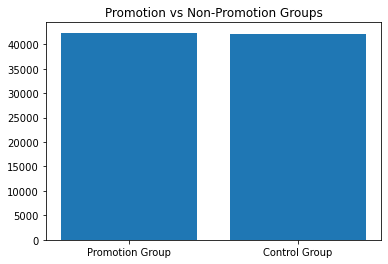

In [11]:
# basic graph of yes and no promotion in training set
x = ['Promotion Group','Control Group']
y = [promotion_yes, promotion_no]

plt.bar(x,y)
plt.title('Promotion vs Non-Promotion Groups') 
# Show graphic
plt.show()

In [13]:
# look at training data split of those that purchase and those that don't
purchase_yes = train_data[train_data['purchase'] == 1].count()[3]
purchase_no = train_data[train_data['purchase'] == 0].count()[3]
print('purchase Yes: ', purchase_yes/train_data.count()[0])
print('purchase No: ', purchase_no/train_data.count()[0])

purchase Yes:  0.012302742091939338
purchase No:  0.9876972579080606


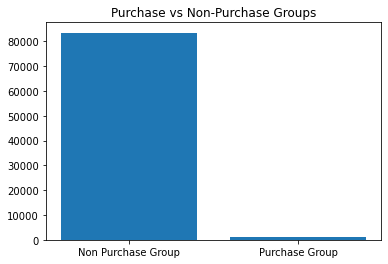

In [14]:
# basic graph of yes and no purchasing decision in training set
x = ['Non Purchase Group', 'Purchase Group']
y = [ purchase_no, purchase_yes]

plt.bar(x,y)
plt.title('Purchase vs Non-Purchase Groups') 
# Show graphic
plt.show()

In [15]:
# look at number of promotion customers that purchase
purchase_promo = train_data[train_data['Promotion'] == 'Yes'].purchase.sum()
purchase_promo

721

In [16]:
# look at control group customers that don't receive a promotion by make a purchase
purchase_ctrl = train_data[train_data['Promotion'] == 'No'].purchase.sum()
purchase_ctrl

319

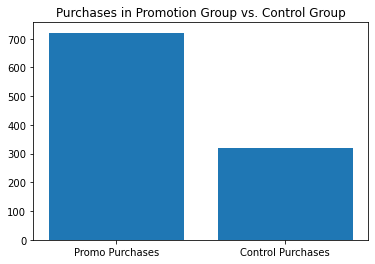

In [17]:
# chart of purchases by promoted group and control group
x = ['Promo Purchases','Control Purchases']
y = [purchase_promo, purchase_ctrl]

plt.bar(x,y)
plt.title('Purchases in Promotion Group vs. Control Group')  
# Show graphic
plt.show()

In [18]:
# rate of purchases by promoted to group
promo_ratio = purchase_promo/promotion_yes
promo_ratio

0.017019167217448776

In [19]:
# rate of purchased by control group
ctrl_ratio = purchase_ctrl/promotion_no
ctrl_ratio

0.007564619397676073

In [20]:
# Incremental Response Rate
IRR = promo_ratio - ctrl_ratio
print(IRR)

0.009454547819772702


In [34]:
#define Net Incremental Revenue (NIR)
"""NIR is $10 times the total number of purchasers that received the promotion minus $0.15 times the number
of promotions sent out, minus $10 times the number of purchasers who were not given the promotion.
𝑁𝐼𝑅=(10⋅𝑝𝑢𝑟𝑐ℎ𝑡𝑟𝑒𝑎𝑡−0.15⋅𝑐𝑢𝑠𝑡𝑡𝑟𝑒𝑎𝑡)−10⋅𝑝𝑢𝑟𝑐ℎ𝑐𝑡𝑟𝑙 """

NIR = (10*purchase_promo-0.15*promotion_yes)-10*purchase_ctrl
print(round(NIR,2))

-2334.6


# Modeling

In [84]:
# load the test data
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [85]:
# setup labels from training data for models
attribute_labels = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Combined Promoted and Non-Promoted Attribute Histograms


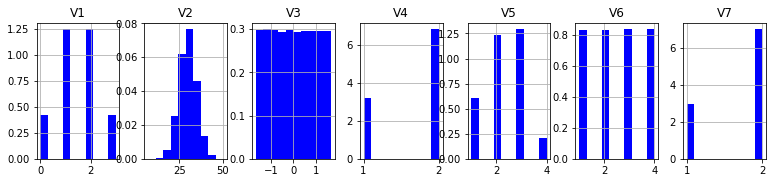

In [92]:
# Features histograms for control group:
train_data.hist(column = attribute_labels, figsize=(15,2.5), layout = (1, 8), density = True, color = 'blue')
print("Combined Promoted and Non-Promoted Attribute Histograms")
plt.show()

Non-Promoted (Green) Attribute Histograms
Promoted (Magenta) Attribute Histograms


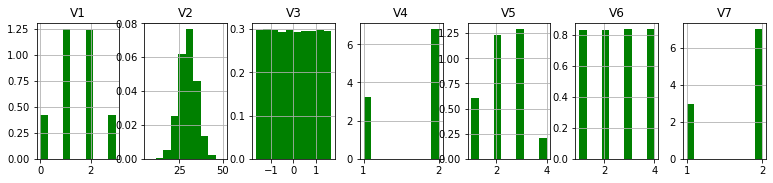

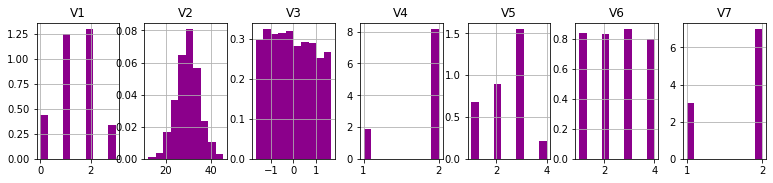

In [93]:
# Features histograms for control group:

print("Non-Promoted (Green) Attribute Histograms")
train_data[train_data['purchase'] == 0].hist(column = attribute_labels, figsize=(15,2.5), layout = (1, 8), 
                                    density = True, color = 'green')

# Features histograms for control group:
print("Promoted (Magenta) Attribute Histograms")
train_data[train_data['purchase'] == 1].hist(column = attribute_labels, figsize=(15,2.5), layout = (1, 8), 
                                    density = True, color = 'darkmagenta')

plt.show()

In [48]:
# add column of responses. Adds label target for model for prediction, if
# the customer receives a promotion and makes a purchase.

def add_target (df):
    response = []

    for index, row in df.iterrows():
        if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
            response.append(1.0)
        else:
            response.append(0.0)
        
    df['response'] = response
    


In [49]:
# add target response column to training data set
add_target(train_data)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2,0.0


In [50]:
# adding blank column to test data for prediction
test_data['response'] = 0

In [51]:
# updated test data set.
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,2,No,0,1,41.376390,1.172517,1,1,2,2,0
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2,0
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2,0
3,10,No,0,2,28.529691,-1.078506,2,3,2,2,0
4,12,No,0,2,32.378538,0.479895,2,2,1,2,0


In [52]:
# Split between training data and testing data
print ("Training data has {} rows...".format(train_data.shape[0]))
print ("Validation set has {} rows...".format(test_data.shape[0]))

Training data has 84534 rows...
Validation set has 41650 rows...


In [53]:
# assign the data to X,Y testing and training dataframes for models
X_train, y_train = train_data[attribute_labels], train_data['response']
X_test, y_test = test_data[attribute_labels], test_data['response']

In [54]:
# very dataframes have equal rows
print(X_train.count()[0], y_train.count(), X_test.count()[0], y_test.count())

84534 84534 41650 41650


In [55]:
# look at training set
X_train.head()

,V1,V2,V3,V4,V5,V6,V7
0,2,30.443518,-1.165083,1,1,3,2
1,3,32.159350,-0.645617,2,3,2,2
2,2,30.431659,0.133583,1,1,4,2
3,0,26.588914,-0.212728,2,1,4,2
4,3,28.044331,-0.385883,1,1,2,2


In [56]:
# look at testing set
X_test.head()

,V1,V2,V3,V4,V5,V6,V7
0,1,41.376390,1.172517,1,1,2,2
1,1,25.163598,0.653050,2,2,2,2
2,1,26.553778,-1.597972,2,3,4,2
3,2,28.529691,-1.078506,2,3,2,2
4,2,32.378538,0.479895,2,2,1,2


In [57]:
# normalize data for logisticregression
def scale_data(df):
    min_max = preprocessing.MinMaxScaler()
    scaled_df = min_max.fit_transform(df.values)
    final_df = pd.DataFrame(scaled_df,columns=[attribute_labels])
    return final_df

X_train_norm = scale_data(X_train)
X_test_norm = scale_data(X_test)

In [58]:
# verify data has been normalizes between 0 - 1
X_train_norm

,V1,V2,V3,V4,V5,V6,V7
0,0.666667,0.539369,0.153846,0.0,0.000000,0.666667,1.0
1,1.000000,0.579021,0.307692,1.0,0.666667,0.333333,1.0
2,0.666667,0.539095,0.538462,0.0,0.000000,1.000000,1.0
3,0.000000,0.450290,0.435897,1.0,0.000000,1.000000,1.0
4,1.000000,0.483924,0.384615,0.0,0.000000,0.333333,1.0
...,...,...,...,...,...,...,...
84529,0.333333,0.531081,0.897436,0.0,0.000000,0.666667,0.0
84530,1.000000,0.610037,0.410256,0.0,0.000000,1.000000,0.0
84531,0.333333,0.563599,0.820513,1.0,0.666667,0.333333,1.0
84532,0.333333,0.708591,0.794872,1.0,0.333333,0.000000,1.0


In [62]:
# logistic regression model
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
y_pred = log_mod.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.0

In [63]:
#Regression model Accuracy
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  1.0


In [64]:
# logistic regression model
model = LogisticRegression(random_state = 43)
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.0

In [65]:
#Log-Regression model Accuracy
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  1.0


### f1_score is 0.0 due to an imbalance in data since there are a small number of actual purchases in the promotion and the control data. This is similar to looking at anomaly data like fraud or spam data.

### One way to fight this issue is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples. 

In [68]:
# up sampling of data using SMOTE
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0.0, 83813), (1.0, 83813)]


In [71]:
# Decisiontreeclassifier model

model = tree.DecisionTreeClassifier()

model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print('F1_score on validation: %.2f'%f1_score(y_test, y_pred))
print('Accuracy score on validation: %.2f'%accuracy_score(y_test, y_pred))

F1_score on validation: 0.00
Accuracy score on validation: 0.99


In [72]:
# SMOTE oversampling
oversample_features = train_data.drop(['ID','Promotion','purchase'],axis=1)
oversample_labels = train_data['purchase']
oversample = SMOTE(random_state=0)
os_features, os_labels = oversample.fit_resample(oversample_features.values, oversample_labels.values)

In [94]:
# Grid search to find the best parameters
parameters = {'max_depth': [2,3,4,5],
             'min_samples_split':[4,6,8,10]}
base_estimator = DecisionTreeClassifier(criterion="entropy", )
grid_obj = GridSearchCV(base_estimator, param_grid=parameters, scoring=make_scorer(f1_score), cv=5)
grid_obj.fit(X_train, y_train)
best_clf = grid_obj.best_estimator_
print ("best_clf\n------")
print (best_clf)

best_clf
------
DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=4)


In [95]:
# Best predicted model from grid search
y_pred = best_clf.predict(X_test)
print('F1_score on validation: %.2f'%f1_score(y_test, y_pred))
print('Accuracy score on validation: %.2f'%accuracy_score(y_test, y_pred))

F1_score on validation: 0.00
Accuracy score on validation: 1.00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [83]:
#Hyperparameters for grid search
hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

In [84]:
# grid search
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=make_scorer(f1_score), cv=5)
grid_obj.fit(X_train, y_train)
best_clf = grid_obj.best_estimator_
print ("best_clf\n------")
print (best_clf)

y_pred = best_clf.predict(X_test)
print('F1_score on validation: %.2f'%f1_score(y_test, y_pred))
print('Accuracy score on validation: %.2f'%accuracy_score(y_test, y_pred))



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

best_clf
------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
F1_score on validation: 0.00
Accuracy score on validation: 1.00


In [98]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [83]:
#transform 0/1 array to Yes/No array
my_map = {0: "No", 1: "Yes"}
promotion = np.vectorize(my_map.get)(y_pred)
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

In [91]:
print(len(promotion))

41650


In [101]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    #predict
    y_pred = model.predict(df)
    
    # transform 0/1 array to N0/Yes 
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(y_pred)
    
    return promotion

In [102]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0058.

Your nir with this strategy is -14.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.005772292993630572, -14.0)